# Multivariate Imputation of Missing Values
This notebook performs multivariate imputation of the missing values in the previously obtained dataset. The imputation is implemented based on scikit learn and uses ExtraTreesRegressor as imputer estimator. The multivariate imputation is repeated four times which yields fours slightly different datasets. The imputation is validated subsequently and compared to simple linear interpolation. Another version of the imputation is implemented based on single linear interpolation. The resulting dataset is likewise saved locally. However, simple linear interpolation turned out to be difficult given the data structure combining grouped information from different levels of analysis. The multivariate imputation is, hence, the basis for the subsequent analysis. 

In [1]:
### Load libraries -------
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import os

# For multivariate imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Pandas parameters
#pd.set_option('display.max_colwidth', -1)
#pd.set_option('display.max_rows', 2000)
#pd.set_option('display.max_columns', 500)

In [2]:
### Define plot parameters ------
plt.rcParams["font.family"] = "garamond"
plt.rcParams.update({'font.size': 22})
rcParams.update({'figure.autolayout': True})

In [3]:
### Define out paths ------

# check if out path exists, if it does not exists add the path
if not os.path.exists('C:\\Users\\frank\\Desktop\\master_thesis_out'):
    os.makedirs('C:\\Users\\frank\\Desktop\\master_thesis_out')

# add subfolders for the out path
out_paths = {
    "desciptive_plots_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_plots_outcome',
    "desciptive_tables_outcome": 'C:\\Users\\frank\\Desktop\\master_thesis_out\desciptive_tables_outcome',
    "data": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data',
    "imp": 'C:\\Users\\frank\\Desktop\\master_thesis_out\data\imp'
}

for key, val in out_paths.items():
    if not os.path.exists(val):
        os.makedirs(val)
        
out_paths["desciptive_tables_outcome"]

'C:\\Users\\frank\\Desktop\\master_thesis_out\\desciptive_tables_outcome'

In [4]:
### Make a dictionary with fancy names of variables to import into functions  -----
dict_feat_names = {
  "foundloc_cat_cat": "Location of Rebel Group Formation to Capital",
  "terrain": "Terrain Ruggedness",
  "forest_cov": "Forest Coverage ",
  "rural": "Rural Population ",
  "oil": "Oil Rents",
  "oil_log": "Oil Rents (log)",
  "ident_ethnicity": "Ethnicity  (Identity)",
  "parent_splinter_nonstate": "Splinter Non-State (Pre-existing Organization)",
  "parent_splinter_state": "Splinter State (Pre-existing Organization)",
  "parent_civil_society": "Civil Society (Pre-existing Organization)",
  "parent_merger": "Merger (Pre-existing Organization)",
  "civil_war_dummy": "Transition to Civil War", 
  "active_year_lag": "Transition to Civil Conflict (lag)",
  "gov_qual": "Quality of Government",
  "milexp_in": "Military Expenditure Index",
  "milper_in": "Military Personnel Index",
  "polity2": "Combined Polity Score", 
  'internet_use': "Internet Usage",
  'internet_use_log': "Internet Usage (log)",
  "age_formation": "Age of Rebel Group Since Formation",
  "ideo_total": "Intensity of Ideology",
  "goal_total": "Intensity of Goals",
}

In [5]:
### Load data --------
df = pd.read_csv(os.path.join(out_paths["data"], "ucdp_forge_wb_qog_polity_owid.csv"))
df.head(3)

,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,ccode_wb,oil,forest_cov,rural,internet_use,gov_qual,milexp_in,milper_in,polity2,terrain
0,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,21.474983,5.572374,43.670,0.0,0.305556,1.84,0.52,-6.0,244.5
1,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,NaN,5.587699,43.135,0.0,0.370370,1.52,0.52,-6.0,244.5
2,1992,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,NaN,5.603023,42.347,0.0,0.467593,1.34,0.51,-6.0,244.5


In [6]:
### Which variables are in data -------------
dat_var = []
for col in df.columns:
    dat_var.append(col)
dat_var

['year',
 'StateAbb',
 'ccode',
 'cname',
 'side_a',
 'side_a_new_id',
 'side_b',
 'side_b_new_id',
 'dyad_name',
 'dyad_new_id',
 'active_year',
 'best',
 'high',
 'low',
 'foundloc',
 'foundyear',
 'foundmo',
 'foundday',
 'fightyear',
 'fightmo',
 'fightday',
 'goalnominal',
 'goalindep',
 'goalauto',
 'goalrights',
 'goalrep',
 'goalchange',
 'goaldem',
 'goalother',
 'goalnote',
 'ideology',
 'ideolcom',
 'ideolleft',
 'ideolright',
 'ideolnat',
 'ideolanti',
 'ideolrel',
 'ideoloth',
 'ideolnote',
 'religious',
 'religion',
 'ethnic',
 'ethnicity',
 'preorg',
 'preorgno',
 'preorgreb',
 'preorgter',
 'preorgpar',
 'preorgmvt',
 'preorgyou',
 'preorglab',
 'preorgmil',
 'preorggov',
 'preorgfmr',
 'preorgrel',
 'preorgfor',
 'preorgref',
 'preorgeth',
 'preorgoth',
 'preorgname',
 'merger',
 'splinter',
 'splinterUCDP',
 'foundloc_cat',
 'foundloc_cat_lab',
 'foundloc_cat_cat',
 'foundloc_cat_cat_lab',
 'age_formation',
 'age_active',
 'goal_territory',
 'goal_gov_represent',
 'go

In [7]:
### Percentage of missingness --------
tab_missing = pd.DataFrame(df[[
         'forest_cov',
         #'rural', has no missing values
         'oil',
         'internet_use',
         'gov_qual',
         'milexp_in',
         'milper_in', 
         'polity2',
     ]].isnull().mean())
tab_missing = tab_missing.reset_index()

# Save percentages in table and import fancy names ---
tab_missing = tab_missing.rename(columns={'index': 'Feature Name', 0: 'Missingness (%)'})
for row in tab_missing.iterrows():
        feat=row[1][0]
        feat_long=dict_feat_names[feat]
        tab_missing.loc[tab_missing['Feature Name'] == feat, 'Feature Name'] = feat_long

# Save table ---        
tab_missing.to_latex(os.path.join(out_paths["desciptive_tables_outcome"], f"tab_missing.tex"), index=False)
tab_missing

,Feature Name,Missingness (%)
0,Forest Coverage,0.063438
1,Oil Rents,0.099274
2,Internet Usage,0.083777
3,Quality of Government,0.210654
4,Military Expenditure Index,0.158838
5,Military Personnel Index,0.158838
6,Combined Polity Score,0.049395


In [8]:
### Multivariate imputation ---------------
# Implementation is based on this source: https://machinelearningmastery.com/iterative-imputation-for-missing-values-in-machine-learning/

for i in [1,2,3,4]: # the imputation is repeated four times 
    # Step 1 Make subset of data for imputation - only explanatory variables 
    feat_imp = df[[
     'goal_total',
     'ideo_total',
     'foundloc_cat_cat',
     'age_formation',
     'ident_ethnicity',
     'parent_splinter_nonstate',
     'parent_splinter_state',
     'parent_civil_society',
     'parent_merger',
     'oil',
     'forest_cov',
     'rural',
     'terrain',
     'gov_qual',
     'milexp_in',
     'milper_in',
     'polity2',
     'internet_use',]]
    df_MICE = feat_imp.copy(deep=True)
    
    # Step 2 Make subset of data which are complete and are not involved in the imputation
    feat_complete = df[[
    'year',
     'StateAbb',
     'ccode',
     'cname',
     'side_a',
     'side_a_new_id',
     'side_b',
     'side_b_new_id',
     'dyad_name',
     'dyad_new_id',
     'active_year',
     'best',
     'high',
     'low',
     'foundloc',
     'foundyear',
     'foundmo',
     'foundday',
     'fightyear',
     'fightmo',
     'fightday',
     'goalnominal',
     'goalindep',
     'goalauto',
     'goalrights',
     'goalrep',
     'goalchange',
     'goaldem',
     'goalother',
     'goalnote',
     'ideology',
     'ideolcom',
     'ideolleft',
     'ideolright',
     'ideolnat',
     'ideolanti',
     'ideolrel',
     'ideoloth',
     'ideolnote',
     'religious',
     'religion',
     'ethnic',
     'ethnicity',
     'preorg',
     'preorgno',
     'preorgreb',
     'preorgter',
     'preorgpar',
     'preorgmvt',
     'preorgyou',
     'preorglab',
     'preorgmil',
     'preorggov',
     'preorgfmr',
     'preorgrel',
     'preorgfor',
     'preorgref',
     'preorgeth',
     'preorgoth',
     'preorgname',
     'merger',
     'splinter',
     'splinterUCDP',
     'foundloc_cat',
     'foundloc_cat_lab',
     'foundloc_cat_cat_lab',
     'age_active',
     'goal_territory',
     'goal_gov_represent',
     'goal_gov_replace',
     'ideo_left',
     'ideo_right',
     'ideo_anti_system',
     'ideo_religious',
     'ident_religious',
     'parent_undefined',
     'ccode_wb',
    ]]

    
    # Step 3 Specify imputer 
    #imputer = IterativeImputer(estimator=
    #                           ExtraTreesRegressor(n_estimators=200, min_samples_leaf=200, 
    #                                               max_samples=200, # <--- limit number of observations in each boostrap sample
    #                                               bootstrap=True, random_state=i),
    #                                               random_state=i, max_iter=10)
    
    # Step 3 Specify imputer 
    imputer = IterativeImputer(estimator=
                               ExtraTreesRegressor(n_estimators=500, 
                                                   min_samples_leaf=200, 
                                                   bootstrap=True, 
                                                   random_state=i),
                                                   random_state=i, 
                                                   max_iter=10)

    
    #https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html
    # - max_iter: Maximum number of imputation rounds to perform before returning the imputations computed during the final round.
    # - random_state:The seed of the pseudo random number generator to use
    #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
    # - n_estimators: The number of trees in the forest.
    # - min_samples_leaf: The minimum number of samples required to be at a leaf node.
    # - max_samples: If bootstrap is True, the number of samples to draw from X to train each base estimator. 
    # - bootstrap: Whether bootstrap samples are used when building trees.
    # - random_state: Controls 3 sources of randomness

    # Step 4 Run imputation and obtain imputed dataset
    imputer.fit(df_MICE)
    df_MICE_trans = imputer.transform(df_MICE)
    df_MICE_trans_df = pd.DataFrame(df_MICE_trans)
    df_MICE_trans_df.columns = [
     'goal_total',
     'ideo_total',
     'foundloc_cat_cat',
     'age_formation',
     'ident_ethnicity',
     'parent_splinter_nonstate',
     'parent_splinter_state',
     'parent_civil_society',
     'parent_merger',
     'oil',
     'forest_cov',
     'rural',
     'terrain',
     'gov_qual',
     'milexp_in',
     'milper_in',
     'polity2',
     'internet_use',]
    
    # Step 5 Merge imputed dataset based on index 
    _ = pd.concat([feat_complete, df_MICE_trans_df], axis=1)
    print(f"Finished Imputation Number {i}")
    
    # Step 6 Save imputed dataset
    _.to_csv(os.path.join(out_paths["imp"], f"df_imp_{i}.csv"), index=False, sep=',')
    print(f"Saved Imputation Number {i}")

Finished Imputation Number 1
Saved Imputation Number 1
Finished Imputation Number 2
Saved Imputation Number 2
Finished Imputation Number 3
Saved Imputation Number 3
Finished Imputation Number 4
Saved Imputation Number 4


In [9]:
### Check if imputation works - original dataset -----
df[["year","cname","oil","forest_cov","rural","terrain","gov_qual","milexp_in", "milper_in","polity2","internet_use"]].head(3)

,year,cname,oil,forest_cov,rural,terrain,gov_qual,milexp_in,milper_in,polity2,internet_use
0,1990,Iran,21.474983,5.572374,43.670,244.5,0.305556,1.84,0.52,-6.0,0.0
1,1991,Iran,NaN,5.587699,43.135,244.5,0.370370,1.52,0.52,-6.0,0.0
2,1992,Iran,NaN,5.603023,42.347,244.5,0.467593,1.34,0.51,-6.0,0.0


In [10]:
### Check if imputation works - only imputed dataset -----
df_MICE_trans_df[["oil","forest_cov","rural","terrain","gov_qual","milexp_in", "milper_in","polity2","internet_use"]].head(3)

,oil,forest_cov,rural,terrain,gov_qual,milexp_in,milper_in,polity2,internet_use
0,21.474983,5.572374,43.670,244.5,0.305556,1.84,0.52,-6.0,0.0
1,10.014203,5.587699,43.135,244.5,0.370370,1.52,0.52,-6.0,0.0
2,9.719407,5.603023,42.347,244.5,0.467593,1.34,0.51,-6.0,0.0


In [11]:
### Check if imputation works - merged dataset which is saved locally -----
_[["year","cname","oil","forest_cov","rural","terrain","gov_qual","milexp_in", "milper_in","polity2","internet_use"]].head(3)

,year,cname,oil,forest_cov,rural,terrain,gov_qual,milexp_in,milper_in,polity2,internet_use
0,1990,Iran,21.474983,5.572374,43.670,244.5,0.305556,1.84,0.52,-6.0,0.0
1,1991,Iran,10.014203,5.587699,43.135,244.5,0.370370,1.52,0.52,-6.0,0.0
2,1992,Iran,9.719407,5.603023,42.347,244.5,0.467593,1.34,0.51,-6.0,0.0


In [12]:
### Function to import mean of features from dataset over time -----
def get_imp_all(lab):
    time_s = pd.DataFrame() # define base dataset
    
    for i in [1,2,3,4]: # repeat for four datasets
        df_imp = pd.read_csv(os.path.join(out_paths["imp"], f"df_imp_{i}.csv"))
       # minimum = df_imp[f'{lab}'].min()
       # maximum = round(df_imp[f'{lab}'].max(),0)
        var = pd.DataFrame(df_imp.groupby('year')[f'{lab}'].mean()) # get mean value over year
        time_s = pd.concat([time_s, var], axis=1) # add mean values for each year to base dataset
    time_s.reset_index(inplace=True)
    time_s.columns =  ["year", f'{lab}_1', f'{lab}_2', f'{lab}_3', f'{lab}_4'] # final dataset
    
    ### plot mean values over year ----
    plt.rcParams.update({'font.size': 22})
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes()

    ax.plot(time_s["year"],time_s[f'{lab}_1'], color="black", linestyle="solid", label = f'{lab}_1');
    ax.plot(time_s["year"],time_s[f'{lab}_2'], color="black", linestyle="dashed", label = f'{lab}_2');
    ax.plot(time_s["year"],time_s[f'{lab}_3'], color="black", linestyle="dotted", label = f'{lab}_3');
    ax.plot(time_s["year"],time_s[f'{lab}_4'], color="black", linestyle='-.', label = f'{lab}_4');

    ax.set(xlabel='Time (years)', ylabel=f'Mean {lab}', title=f'Mean {lab} over Time') 
    ax.legend(loc='upper right', prop={'size': 15})
   # ax.set_ylim([minimum,maximum])
    plt.show()

    return time_s, fig

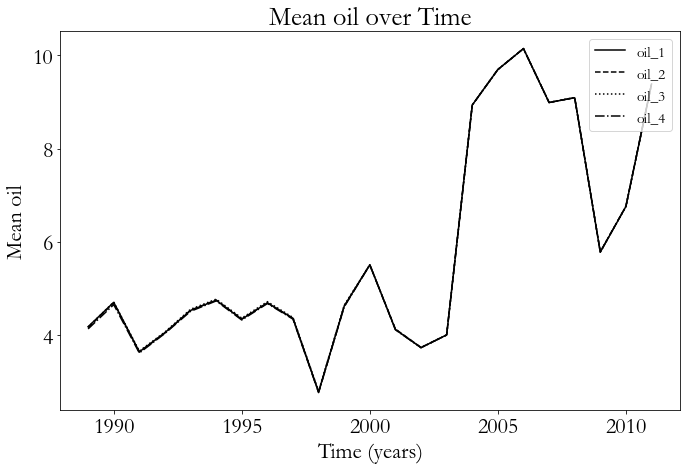

,year,oil_1,oil_2,oil_3,oil_4
0,1989,4.186170,4.165865,4.179453,4.138342
1,1990,4.708321,4.699878,4.714635,4.659014
2,1991,3.647646,3.641126,3.664806,3.622355


In [13]:
### Get oil -----
oil_imp, plot = get_imp_all('oil')
oil_imp.head(3)

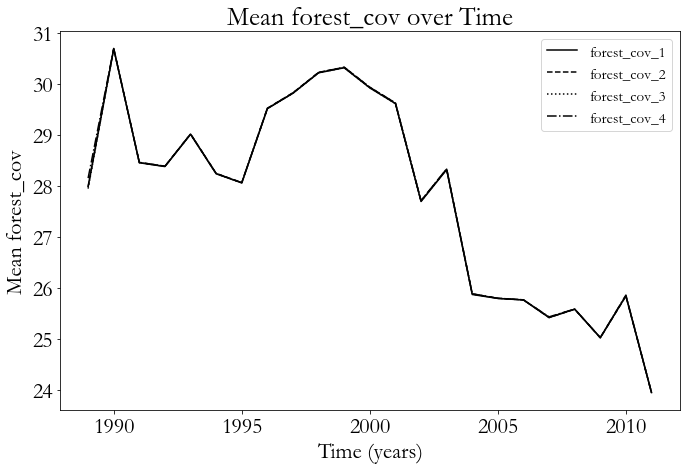

,year,forest_cov_1,forest_cov_2,forest_cov_3,forest_cov_4
0,1989,27.983841,27.974801,27.940047,28.146597
1,1990,30.679630,30.686122,30.682427,30.685703
2,1991,28.447020,28.454310,28.449826,28.453325


In [14]:
### Get forest_cov -----
forest_cov_imp, plot = get_imp_all('forest_cov')
forest_cov_imp.head(3)

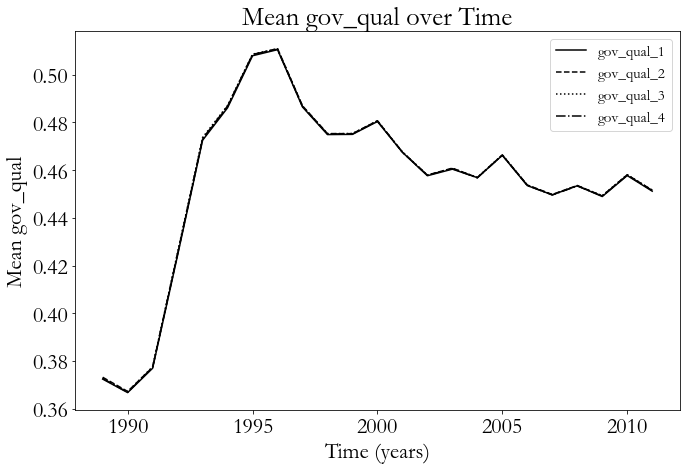

,year,gov_qual_1,gov_qual_2,gov_qual_3,gov_qual_4
0,1989,0.372387,0.373159,0.372764,0.372649
1,1990,0.366721,0.367209,0.367027,0.366841
2,1991,0.376936,0.377371,0.377560,0.377364


In [15]:
### Get gov_qual -----
gov_qual_imp, plot = get_imp_all('gov_qual')

# Save table
gov_qual_imp.to_latex(os.path.join(out_paths["desciptive_tables_outcome"], f"_gov_qual_imp.tex"), index=False)

gov_qual_imp.head(3)

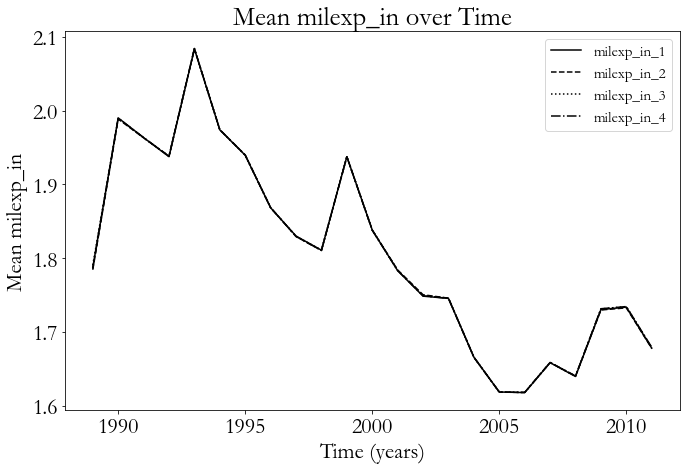

,year,milexp_in_1,milexp_in_2,milexp_in_3,milexp_in_4
0,1989,1.787447,1.784302,1.790654,1.785679
1,1990,1.990289,1.988724,1.989758,1.989809
2,1991,1.963520,1.963304,1.963286,1.963615


In [16]:
### Get milexp_in -----
milexp_in_imp, plot = get_imp_all('milexp_in')

# Save table
milexp_in_imp.to_latex(os.path.join(out_paths["desciptive_tables_outcome"], f"_milexp_in_imp.tex"), index=False)

milexp_in_imp.head(3)

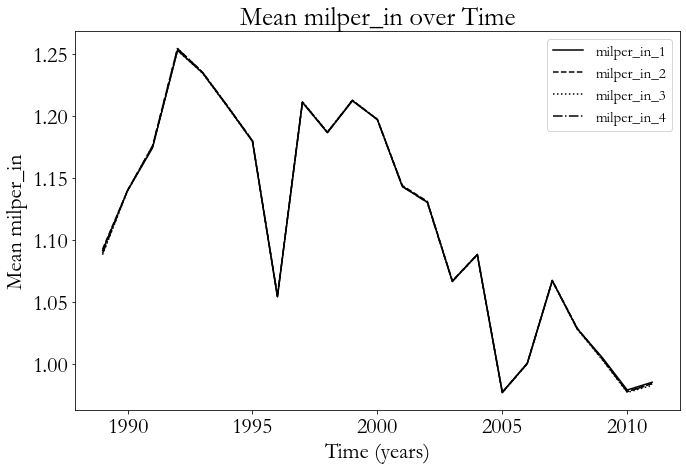

,year,milper_in_1,milper_in_2,milper_in_3,milper_in_4
0,1989,1.091168,1.092280,1.087857,1.088859
1,1990,1.139537,1.139657,1.139480,1.139705
2,1991,1.174070,1.175516,1.174337,1.175572


In [17]:
### Get milper_in -----
milper_in_imp, plot = get_imp_all('milper_in')

# Save table
milper_in_imp.to_latex(os.path.join(out_paths["desciptive_tables_outcome"], f"_milper_in_imp.tex"), index=False)

milper_in_imp.head(3)

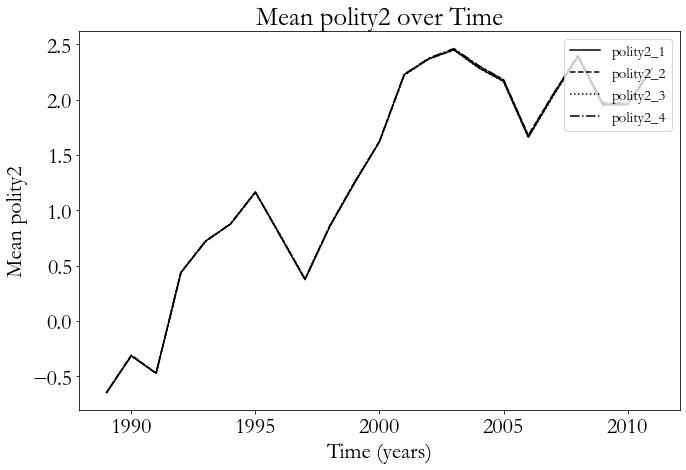

,year,polity2_1,polity2_2,polity2_3,polity2_4
0,1989,-0.646341,-0.646341,-0.646341,-0.646341
1,1990,-0.315106,-0.307714,-0.313115,-0.311414
2,1991,-0.471712,-0.470242,-0.472518,-0.473032


In [18]:
### Get polity2 -----
polity2_imp, plot = get_imp_all('polity2')
polity2_imp.head(3)

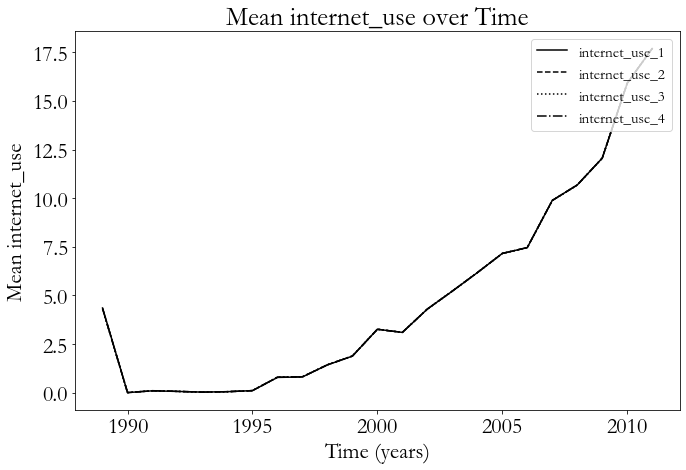

,year,internet_use_1,internet_use_2,internet_use_3,internet_use_4
0,1989,4.357672,4.332584,4.308891,4.325895
1,1990,0.008792,0.008792,0.008792,0.008792
2,1991,0.100745,0.102856,0.105078,0.106977


In [19]:
### Get internet_use -----
internet_use_imp, plot = get_imp_all('internet_use')
internet_use_imp.head(3)

In [20]:
### Check if all missing values have been filled --------
df_imp = pd.read_csv(os.path.join(out_paths["imp"], f"df_imp_1.csv"))

tab_missing = pd.DataFrame(df_imp[[
         'forest_cov',
         #'rural', has no missing values
         'oil',
         'internet_use',
         'gov_qual',
         'milexp_in',
         'milper_in', 
         'polity2',
     ]].isnull().mean())
tab_missing

,0
forest_cov,0.0
oil,0.0
internet_use,0.0
gov_qual,0.0
milexp_in,0.0
milper_in,0.0
polity2,0.0


In [21]:
### Check some of the values manually ---
# the imputation does not necessarily look good from face validity 
# that is a disadvantage of multivariate imputation because the values do not necessarily make sense 
# since they are based on variance in the data rather than the specific scales
df_imp = pd.read_csv(os.path.join(out_paths["imp"], "df_imp_1.csv"))
len(df_imp)

2065

In [22]:
### Imputed dataset -----
df_imp[["year", "cname", "forest_cov"]].loc[df_imp["cname"]=="Myanmar"].head(4) # there is a huge gap from 1989 to 1990

,year,cname,forest_cov
33,1989,Myanmar,36.691943
34,1990,Myanmar,60.009303
35,1991,Myanmar,59.343641
36,1992,Myanmar,58.677978


In [23]:
### Dataset with missing values -----
df[["year", "cname", "forest_cov", "dyad_new_id"]].loc[df["cname"]=="Myanmar"].head(4)

,year,cname,forest_cov,dyad_new_id
33,1989,Myanmar,NaN,428
34,1990,Myanmar,60.009303,428
35,1991,Myanmar,59.343641,428
36,1992,Myanmar,58.677978,428


In [24]:
### Check if simple linear imputation performs better -----

In [25]:
### List with unique dyad ids -----
df["dyad_new_id"].unique()

array([  406,   411,   412,   426,   428,   429,   430,   434,   442,
         445,   446,   451,   452,   453,   459,   461,   469,   474,
         475,   476,   477,   478,   479,   480,   508,   511,   521,
         523,   524,   525,   532,   533,   537,   549,   550,   558,
         559,   562,   564,   565,   571,   575,   584,   585,   586,
         588,   593,   594,   595,   596,   597,   606,   607,   608,
         609,   610,   611,   612,   613,   615,   616,   617,   618,
         619,   620,   621,   622,   623,   624,   626,   628,   631,
         632,   640,   644,   646,   647,   654,   656,   657,   658,
         659,   663,   664,   665,   666,   667,   668,   669,   670,
         674,   686,   688,   689,   690,   691,   692,   693,   697,
         705,   709,   710,   711,   712,   714,   718,   719,   720,
         721,   722,   724,   726,   727,   729,   732,   733,   734,
         735,   739,   740,   742,   744,   745,   746,   747,   748,
         749,   750,

In [26]:
### Sort data before linear imputation -----
df = df.sort_values(["dyad_new_id", "StateAbb", "year"], ascending = (True, True, True))
df.head(3)

,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,ccode_wb,oil,forest_cov,rural,internet_use,gov_qual,milexp_in,milper_in,polity2,terrain
1518,1989,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,15.171111,NaN,44.206,NaN,0.305556,NaN,NaN,-6.0,244.5
0,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,21.474983,5.572374,43.670,0.0,0.305556,1.84,0.52,-6.0,244.5
1,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,NaN,5.587699,43.135,0.0,0.370370,1.52,0.52,-6.0,244.5


In [27]:
### Simple linear interpolation (ignore groups) ------
df_interpolated = df.interpolate(method ='linear', limit_direction="both")
df_interpolated.head(3)

,year,StateAbb,ccode,cname,side_a,side_a_new_id,side_b,side_b_new_id,dyad_name,dyad_new_id,...,ccode_wb,oil,forest_cov,rural,internet_use,gov_qual,milexp_in,milper_in,polity2,terrain
1518,1989,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,15.171111,5.572374,44.206,0.0,0.305556,1.84,0.52,-6.0,244.5
0,1990,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,21.474983,5.572374,43.670,0.0,0.305556,1.84,0.52,-6.0,244.5
1,1991,IRN,630,Iran,Government of Iran,114,KDPI,164,Government of Iran - KDPI,406,...,IRN,23.982789,5.587699,43.135,0.0,0.370370,1.52,0.52,-6.0,244.5


In [28]:
### Check is all missing values have been filled in simple linear interpolation --------
tab_missing = pd.DataFrame(df_interpolated[[
         'forest_cov',
         #'rural', has no missing values
         'oil',
         'internet_use',
         'gov_qual',
         'milexp_in',
         'milper_in', 
         'polity2',
     ]].isnull().mean())
tab_missing

,0
forest_cov,0.0
oil,0.0
internet_use,0.0
gov_qual,0.0
milexp_in,0.0
milper_in,0.0
polity2,0.0


In [29]:
### Dataset with missing values -----
df_interpolated[["year", "cname", "internet_use", "dyad_new_id"]].loc[(df["cname"]=="Afghanistan")].head(3)
# does not really make sense for some observations since cases are grouped

,year,cname,internet_use,dyad_new_id
762,1989,Afghanistan,2.15,724
763,1990,Afghanistan,0.00,724
764,1991,Afghanistan,0.00,724


In [30]:
### Dataset with missing values -----
df[["year", "cname", "internet_use", "dyad_new_id"]].loc[df["cname"]=="Afghanistan"].head(3)

,year,cname,internet_use,dyad_new_id
762,1989,Afghanistan,NaN,724
763,1990,Afghanistan,0.0,724
764,1991,Afghanistan,0.0,724


In [31]:
### Interpolation for grouped data ------
df_interpoalt_groupby = df.groupby(["dyad_new_id"]).apply(lambda df: df.fillna(df.interpolate(method ='linear', limit_direction="both")))
df_interpoalt_groupby[["year", "cname", "internet_use", "dyad_new_id"]].loc[(df["cname"]=="Afghanistan")].head(3) # works better from face validity

,year,cname,internet_use,dyad_new_id
762,1989,Afghanistan,0.0,724
763,1990,Afghanistan,0.0,724
764,1991,Afghanistan,0.0,724


In [32]:
### Check missing values in added variables for grouped linear interpolation ----
missing = df_interpoalt_groupby[["StateAbb", "year", "dyad_new_id",
         'forest_cov',
         #'rural', has no missing values
         'oil',
         'internet_use',
         'gov_qual',
         'milexp_in',
         'milper_in', 
         'polity2',
     ]]
null_data = missing[missing.isnull().any(axis=1)]
null_data.sort_values(by=["StateAbb", "year"])
null_data[["StateAbb", "year", "dyad_new_id",'forest_cov',
         #'rural', has no missing values
         'oil',
         'internet_use',
         'gov_qual',
         'milexp_in',
         'milper_in', 
         'polity2',]].head(3) 
# There is another problem with this solution which comes from combining data one different levels of analysis
# On the actor-level some observations are missing completely or only occur once. These observations cannot be filled in with this approach.
# --> multiple imputation is best/only option

,StateAbb,year,dyad_new_id,forest_cov,oil,internet_use,gov_qual,milexp_in,milper_in,polity2
32,PAR,1989,426,NaN,0.000000,NaN,0.111111,NaN,NaN,2.0
57,MYA,2010,430,48.129382,0.761831,0.25,0.333333,NaN,NaN,-6.0
58,MYA,2011,430,47.683706,0.943550,0.98,0.333333,NaN,NaN,-3.0


In [33]:
### Save interpolated dataset ------
df_interpolated.to_csv(os.path.join(out_paths["imp"], f"df_imp_simple_interpolated.csv"), index=False, sep=',')